In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_anomaly_detection

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


# Anomaly Detection via Isolation
<img src="_static/images/aai_presentation_first_slide.svg" alt="Snow" style="width:100%;">

In [6]:
import ipywidgets as widgets
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px


from ipywidgets import interact
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from tensorflow import keras
from tqdm import tqdm

from tfl_training_anomaly_detection.exercise_tools import (
    evaluate, 
    get_kdd_data, 
    get_house_prices_data, 
    create_distributions, 
    contamination, 
    perform_rkde_experiment, 
    get_mnist_data
)
from tfl_training_anomaly_detection.vae import VAE, build_decoder_mnist, build_encoder_minst, build_contaminated_minst

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)


## Exercise: Network Security

In the final exercise of today you will have to develop an anomaly detection system for network traffic.

### Briefing
A large e-commerce company __A__ is experiencing downtime due to attacks on their infrastructure.
You were instructed to develop a system that can detect malicious connections to the infrastructure.
It is planned that suspicious clients will be banned.

Another data science team already prepared the connection data of the last year for you. They also separated a test set and manually identified and labeled attacks in that data.

### The Data
We will work on a version of the classic KDD99 data set.

#### Kddcup 99 Data Set
======================

The KDD Cup '99 dataset was created by processing the tcp dump portions
of the 1998 DARPA Intrusion Detection System (IDS) Evaluation dataset,
created by MIT Lincoln Lab [1]. The artificial data (described on the `dataset's
homepage <https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html>`_) was
generated using a closed network and hand-injected attacks to produce a
large number of different types of attack with normal activity in the
background.

    =========================   ====================================================
    Samples total               976158
    Dimensionality              41
    Features                    string (str), discrete (int), continuous (float)
    Targets                     str, 'normal.' or name of the anomaly type
    Proportion of Anomalies     1%
    =========================   ====================================================


### Task
You will have to develop the system on your own. In particular, you will have to
- Explore the data.
- Choose an algorithm.
- Find a good detection threshold.
- Evaluate and summarize your results.
- Estimate how much __A__ could save through the use of your system.

In [7]:
X_train,X_test,y_test = get_kdd_data()

## Explore Data

In [8]:
#
# Add your exploration code
#
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [9]:
# get description
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,80524,80524,80524,80524,80524,80524,80524,80524,80524,80524,...,80524,80524,80524.0,80524.0,80524.0,80524.0,80524.0,80524.0,80524.0,80524.0
unique,2025,3,52,9,3026,9749,2,1,2,19,...,256,256,101.0,96.0,101.0,53.0,89.0,50.0,101.0,101.0
top,0,b'tcp',b'http',b'SF',105,0,0,0,0,0,...,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,71099,62167,49443,75341,5928,13968,80522,80524,80523,80067,...,34715,45937,52113.0,51478.0,27073.0,40645.0,75976.0,75534.0,72976.0,73043.0


In [10]:
# get better description
X_train.drop(columns=[1,2,3]).astype(float).describe()

,0,4,5,6,7,8,9,10,11,12,...,31,32,33,34,35,36,37,38,39,40
count,80524.000000,8.052400e+04,8.052400e+04,80524.000000,80524.0,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000,...,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000,80524.000000
mean,212.520826,1.132199e+03,3.334559e+03,0.000025,0.0,0.000037,0.045092,0.000224,0.694675,0.034362,...,152.229584,201.268951,0.840326,0.056082,0.154018,0.023329,0.010110,0.009103,0.056911,0.055090
std,1335.658133,3.327535e+04,3.920496e+04,0.004984,0.0,0.010572,0.865373,0.022837,0.460548,4.447863,...,103.504684,88.080978,0.311756,0.179046,0.307295,0.049320,0.093601,0.090608,0.223601,0.217788
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.460000e+02,1.050000e+02,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,40.000000,168.000000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.320000e+02,3.920000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,175.000000,255.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.170000e+02,2.012000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,0.090000,0.030000,0.000000,0.000000,0.000000,0.000000
max,30190.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Check for NaNs
print("Number of NaNs: {}".format(X_train.isna().sum().sum()))

Number of NaNs: 0


In [12]:
#
# Add your preperation code here
#

# Encode string features
binarizer = LabelBinarizer()
one_hots = None
one_hots_test = None
for i in [1, 2, 3]:
    binarizer.fit(X_train[[i]].astype(str))
    if one_hots is None:
        one_hots = binarizer.transform(X_train[[i]].astype(str))
        one_hots_test = binarizer.transform(X_test[[i]].astype(str))
    else:
        one_hots = np.concatenate([one_hots, binarizer.transform(X_train[[i]].astype(str))], axis=1)
        one_hots_test = np.concatenate([one_hots_test, binarizer.transform(X_test[[i]].astype(str))], axis=1)

X_train.drop(columns=[1,2,3], inplace=True)
X_train_onehot = pd.DataFrame(np.concatenate([X_train.values, one_hots], axis=1))

X_test.drop(columns=[1,2,3], inplace=True)
X_test_onehot = pd.DataFrame(np.concatenate([X_test.values, one_hots_test], axis=1))

In [13]:
# Encode y
y_test_bin = np.where(y_test == b'normal.', 0, 1)


In [14]:
# Remove suspicious data
# This step is not strictly neccessary but can improve performance
suspicious = X_train_onehot.apply(lambda col: (col - col.mean()).abs() > 4 * col.std() if col.std() > 1 else False)
suspicious = suspicious.any(axis=1)# 4 sigma rule
print('filtering {} suspicious data points'.format(suspicious.sum()))
X_train_clean = X_train_onehot[~suspicious]

filtering 2932 suspicious data points


## Choose Algorithm

In [15]:
# TODO: implement proper model selection
iforest = IsolationForest()
iforest.fit(X_train_clean)

IsolationForest()

In [16]:
# find best threshold
X_test_onehot, X_val_onehot, y_test_bin, y_val_bin = train_test_split(X_test_onehot, y_test_bin, test_size=.5)
y_score = -iforest.score_samples(X_val_onehot).reshape(-1)

## Evaluate Solution

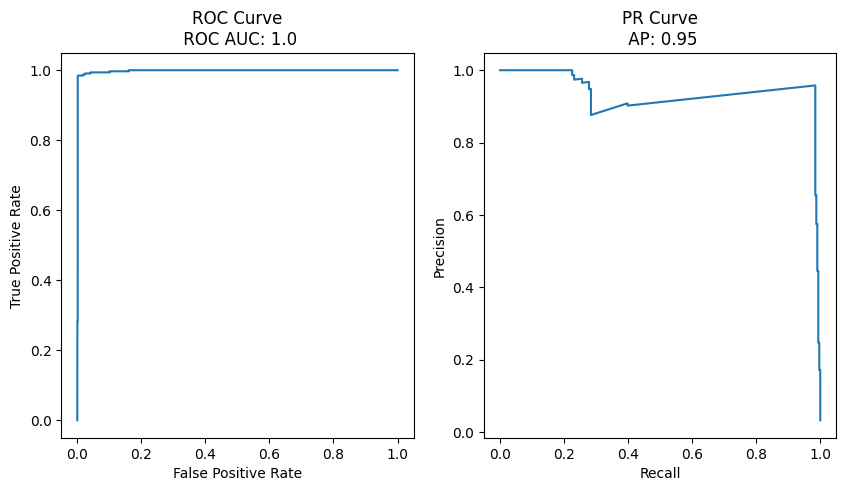

Precision: 0.9413489736070382
Recall: 0.9846625766871165
F1: 0.9625187406296851


In [17]:
#
# Insert evaluation code
#

# calculate scores if any anomaly is present
if np.any(y_val_bin == 1):
    eval = evaluate(y_val_bin, y_score)
    prec, rec, thr = eval['PR']
    f1s = 2 * (prec * rec)/(prec + rec)
    threshold = thr[np.argmax(f1s)]

    y_score = -iforest.score_samples(X_test_onehot).reshape(-1)
    y_pred = np.where(y_score < threshold, 0, 1)

    print('Precision: {}'.format(metrics.precision_score(y_test_bin, y_pred)))
    print('Recall: {}'.format(metrics.recall_score(y_test_bin, y_pred)))
    print('F1: {}'.format(metrics.f1_score(y_test_bin, y_pred)))

<img src="_static/images/aai_presentation_last_slide.svg" alt="Snow" style="width:100%;">